<a href="https://colab.research.google.com/github/linbeta/ingredients_recognition_model/blob/main/04_%E9%A0%90%E6%B8%AC%E5%9C%96%E7%89%87%E5%89%8D%E8%99%95%E7%90%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 用切割預測照片的方法處理多分類預測機率問題

1. 縮小預測圖片範圍
2. 把多分類問題轉化成類單分類問題(範圍縮小)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 載入類別對照表(共71類)
# https://drive.google.com/file/d/13bL3CO52WM70pqIpWI4LXJ2T2kiL1BFK/view?usp=sharing
!gdown --id '13bL3CO52WM70pqIpWI4LXJ2T2kiL1BFK'

Downloading...
From: https://drive.google.com/uc?id=13bL3CO52WM70pqIpWI4LXJ2T2kiL1BFK
To: /content/71_classes_labels.txt
100% 878/878 [00:00<00:00, 1.55MB/s]


In [3]:
# 從類別編號對照表中讀取類別數字對應的類別名稱
class_dict = {}
with open('./71_classes_labels.txt', "r", encoding='utf-8') as f:
  for line in f:
    (key, value) = line.split()
    class_dict[key.zfill(2)] = value
print(class_dict)


{'00': '空心菜', '01': '小白菜', '02': '青江菜', '03': '豆芽菜', '04': '地瓜葉', '05': '花椰菜', '06': '芥藍菜', '07': '大白菜', '08': '高麗菜', '09': '長年菜', '10': '金針菇', '11': '杏鮑菇', '12': '香菇', '13': '乾香菇', '14': '綜合菇類', '15': '豬五花', '16': '豬肉片', '17': '豬絞肉', '18': '牛肉', '19': '羊肉', '20': '奶油', '21': '雞肉', '22': '魚肉', '23': '雞胸肉', '24': '鮭魚', '25': '紅蘿蔔', '26': '白蘿蔔', '27': '馬鈴薯', '28': '地瓜', '29': '青椒', '30': '甜椒', '31': '雞蛋', '32': '番茄', '33': '蝦子', '34': '洋蔥', '35': '辣椒', '36': '蘋果', '37': '九層塔', '38': '八角', '39': '秋葵', '40': '蔥', '41': '薑', '42': '蒜頭', '43': '猴頭菇', '44': '玉米', '45': '豆腐', '46': '板豆腐', '47': '豆干', '48': '鳳梨', '49': '韭菜', '50': '這不是食材', '51': '蛤蠣', '52': '小黃瓜', '53': '胡瓜', '54': '櫛瓜', '55': '茄子', '56': '絲瓜', '57': '南瓜', '58': '橘子', '59': '香蕉', '60': '奇異果', '61': '白飯', '62': '雞翅', '63': '雞腿', '64': '苦瓜', '65': '福山萵苣_又名大陸妹', '66': '皮蛋', '67': '豆皮', '68': '木耳', '69': '茼蒿', '70': '小松菜'}


In [4]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np
from glob import glob
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image as im
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.utils import plot_model

In [ ]:
# 28分類 https://drive.google.com/file/d/1-4UntGiDjT1RRPVtWM56V1sdvlyNvYFR/view?usp=sharing
# !gdown --id '1-4UntGiDjT1RRPVtWM56V1sdvlyNvYFR' -O DN169_model.h5
# 65分類 https://drive.google.com/file/d/1-2u5_KtpXGdUyS0SZYks0U1Dr_83v7wx/view?usp=sharing
!gdown --id '1-5DMK0rrIkhLItZngU_fI4op3a8CgXDL' -O DN169_model_65.h5

Downloading...
From: https://drive.google.com/uc?id=1-5DMK0rrIkhLItZngU_fI4op3a8CgXDL
To: /content/DN169_model_65.h5
100% 63.4M/63.4M [00:00<00:00, 153MB/s] 


In [5]:
# 上線版：65類的MobileNetV2模型
!gdown --id '1-3B7D3-E7s2z-0qkyfzaqqLjKNIH3NI0' -O 1223_MNv2_model.h5

Downloading...
From: https://drive.google.com/uc?id=1-3B7D3-E7s2z-0qkyfzaqqLjKNIH3NI0
To: /content/1223_MNv2_model.h5
100% 18.3M/18.3M [00:00<00:00, 112MB/s] 


In [ ]:
# https://drive.google.com/file/d/1-4UntGiDjT1RRPVtWM56V1sdvlyNvYFR/view?usp=sharing
# !gdown --id '1-EXFdbdDyV_atDMoiFAouh_W96P_4prq' -O MobileNet_model.h5
!gdown --id '1--GuZRnTA0VfgCK6SkvcLTn4UBGqX0fT' -O EffB0.h5

Downloading...
From: https://drive.google.com/uc?id=1--GuZRnTA0VfgCK6SkvcLTn4UBGqX0fT
To: /content/EffB0.h5
100% 25.7M/25.7M [00:00<00:00, 70.3MB/s]


In [6]:
# 載入模型
model = load_model('/content/1223_MNv2_model.h5')

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [8]:
"""
切圖：對預測圖片進行預處理的函式
"""

# 將圖片填成正方形
def fill_image(image):
    width, height = image.size
    # 長寬取大的值作為邊長
    new_image_length = width if width > height else height
    # 做一張白色的新圖片
    new_image = Image.new(image.mode, (new_image_length, new_image_length), color='white')
    # 將圖片貼在新圖上，(x,y)表示黏貼原圖相對白底的起始位置
    if width > height:
        new_image.paste(image, (0, int((new_image_length - height) / 2)))
    else:
        new_image.paste(image, (int((new_image_length - width) / 2),0))
    return new_image

# 切圖
def cut_image(image, num=3):
    width, height = image.size
    item_width = int(width / num)
    box_list = []
    # (left, upper, right, lower)
    for i in range(0, num):
        for j in range(0, num):
            # print((i*item_width,j*item_width,(i+1)*item_width,(j+1)*item_width))
            box = (j*item_width,i*item_width,(j+1)*item_width,(i+1)*item_width)
            box_list.append(box)
    
    image_list = [image.crop(box) for box in box_list]
    # print(image_list)

    return image_list

In [9]:
# 之前model用的28個類別class_list
# class_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '25', '26', '27', '28', '31', '34', '43', '45', '46', '47', '49', '55', '66', '67']
# 之前model用的65個類別class_list
class_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '36', '40', '41', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '69', '70']

# 將預測值對應到class_list，再用這個值對應到class_dict標出中文
trans = [class_dict[i] for i in class_list]

In [10]:
# 原圖直接跑預測，機率大於0.2才印出
def predict_origin(img):
  img = ImageOps.fit(img, (224, 224))
  img = im.img_to_array(img)
  img = preprocess_input(img)
  img_np = np.array(img).reshape(1, 224, 224, 3)
  ### 預測 ###
  pre = model.predict(img_np)
  ans = list(np.array(trans)[pre[0] > 0.2])
  return ans, pre


# 動態切圖，預設切成3x3，num有指定可切成不同num x num張數
def predict_dynamic_cut(img, num=3):
  # 補值讓讓片變成正方形
  img = fill_image(img)
  # 切為2X2
  img_list = cut_image(img, num)

  answer = []
  for i, img in enumerate(img_list):
    img = ImageOps.fit(img, (224, 224))
    img_np = np.array(img).reshape(1, 224, 224, 3)
    pp_img = preprocess_input(img_np)
    pre = model.predict(pp_img)
    ans = list(np.array(trans)[pre[0] > 0.1])
    print(f"小圖{i + 1} 預測結果： {ans}")
    if '這不是食材' in ans:
        ans.remove("這不是食材")
    answer += ans
    # if i == 0:
    #   for p, val in zip(pre[0], trans):
    #     print(val, "的機率:", round(p, 3))
  # print("pre: ", pre)
  answer = list(set(answer))
  return answer

In [11]:
import requests
import time

原圖預測：  ['番茄']
小圖1 預測結果： ['雞蛋']
小圖2 預測結果： ['番茄']
小圖3 預測結果： ['雞蛋']
小圖4 預測結果： ['番茄']
看起來像是有這些：  ['番茄', '雞蛋']


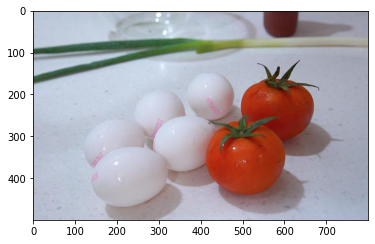

In [12]:
### 用網址預測單張照片+預處理 ###
url = "https://img.ltn.com.tw/Upload/food/page/2020/04/18/200418-10585-1-SQIam.jpg"#@param {type:"string"}

response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB")
time_a = time.time()

# print(img)
plt.imshow(img)

result_1, prediction = predict_origin(img)
print("原圖預測： ",result_1)
# for p, val in zip(prediction[0], trans):
#   print(val, "的機率:", round(p, 3))

# print("===============分隔線=================")

result_2 = predict_dynamic_cut(img, 2)
print("看起來像是有這些： ", result_2)
time_b = time.time()

# print(f"時間差：{time_b - time_a}")
# for p, val in zip(pre[0], trans):
#     print(val, "的機率:", round(p, 3))


### 測試照片

https://cdn.cybassets.com/s/files/9949/ckeditor/pictures/content_f47fba9b-a08b-4503-8b73-00bc90287d8b.jpg


https://i.ytimg.com/vi/R1JWBi06sIs/maxresdefault.jpg

https://i.ytimg.com/vi/50xZ7rpxTss/sddefault.jpg


https://i.ytimg.com/vi/RqlcAi6zbrM/maxresdefault.jpg

https://imgs.gvm.com.tw/upload/gallery/20200513/72413_01.jpg


https://i.epochtimes.com/assets/uploads/2017/12/Fotolia_62162148_Subscription_Monthly_M-600x400.jpg


https://i.ytimg.com/vi/eRBh4sLITv4/maxresdefault.jpg


https://img.ltn.com.tw/Upload/food/page/2020/04/18/200418-10585-1-SQIam.jpg

https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTU2v07uaSuepaXUGDfUD16Zhd8dpJK14sPZt5f8-W59hfOEEpKTW8GgbSqV2ecDEXVo4Y&usqp=CAU



https://img.cook1cook.com/upload/step/25/89/2824214103627222589.jpg

https://img.cook1cook.com/upload/step/55/82/7867414739405475582.JPG

https://lh3.googleusercontent.com/proxy/SPko3iAFqKW0ShJltejHg5CE1uc4unkbvVc4waYFyJ2qWbGXa5w9jMP31bY9B4Lmz2WC00qmwGDzMVgKDeRhmG6js8hfBU_YWm1r09nAib_l






In [13]:
# 展開原圖預測result_1的機率
for p, val in zip(prediction[0], trans):
    print(val, "的機率:", round(p, 3))

空心菜 的機率: 0.0
小白菜 的機率: 0.0
青江菜 的機率: 0.0
豆芽菜 的機率: 0.0
地瓜葉 的機率: 0.0
花椰菜 的機率: 0.0
芥藍菜 的機率: 0.0
大白菜 的機率: 0.0
高麗菜 的機率: 0.0
長年菜 的機率: 0.0
金針菇 的機率: 0.0
杏鮑菇 的機率: 0.0
香菇 的機率: 0.0
乾香菇 的機率: 0.0
綜合菇類 的機率: 0.0
豬五花 的機率: 0.0
豬肉片 的機率: 0.0
豬絞肉 的機率: 0.0
牛肉 的機率: 0.0
羊肉 的機率: 0.0
奶油 的機率: 0.0
雞肉 的機率: 0.0
魚肉 的機率: 0.0
雞胸肉 的機率: 0.0
鮭魚 的機率: 0.0
紅蘿蔔 的機率: 0.0
白蘿蔔 的機率: 0.0
馬鈴薯 的機率: 0.0
地瓜 的機率: 0.0
青椒 的機率: 0.0
甜椒 的機率: 0.0
雞蛋 的機率: 0.0
番茄 的機率: 1.0
蝦子 的機率: 0.0
洋蔥 的機率: 0.0
蘋果 的機率: 0.0
蔥 的機率: 0.0
薑 的機率: 0.0
猴頭菇 的機率: 0.0
玉米 的機率: 0.0
豆腐 的機率: 0.0
板豆腐 的機率: 0.0
豆干 的機率: 0.0
鳳梨 的機率: 0.0
韭菜 的機率: 0.0
這不是食材 的機率: 0.0
蛤蠣 的機率: 0.0
小黃瓜 的機率: 0.0
胡瓜 的機率: 0.0
櫛瓜 的機率: 0.0
茄子 的機率: 0.0
絲瓜 的機率: 0.0
南瓜 的機率: 0.0
橘子 的機率: 0.0
香蕉 的機率: 0.0
奇異果 的機率: 0.0
白飯 的機率: 0.0
雞翅 的機率: 0.0
雞腿 的機率: 0.0
苦瓜 的機率: 0.0
福山萵苣_又名大陸妹 的機率: 0.0
皮蛋 的機率: 0.0
豆皮 的機率: 0.0
茼蒿 的機率: 0.0
小松菜 的機率: 0.0


In [ ]:
# https://drive.google.com/file/d/1kUP6Qe6AgEXLrA7OvNrxlZhXrfqNft6u/view?usp=sharing
!gdown --id '1kUP6Qe6AgEXLrA7OvNrxlZhXrfqNft6u' -O val_img_square.zip
!unzip val_img_square.zip

原圖預測：  ['櫛瓜']
===============分隔線=================
小圖1 預測結果： ['雞胸肉']
小圖2 預測結果： []
小圖3 預測結果： []
小圖4 預測結果： ['馬鈴薯']
小圖5 預測結果： ['雞胸肉']
小圖6 預測結果： ['雞蛋']
小圖7 預測結果： ['小黃瓜']
小圖8 預測結果： ['胡瓜']
小圖9 預測結果： ['胡瓜', '櫛瓜']
看起來像是有這些：  ['胡瓜', '雞胸肉', '馬鈴薯', '雞蛋', '小黃瓜', '櫛瓜']


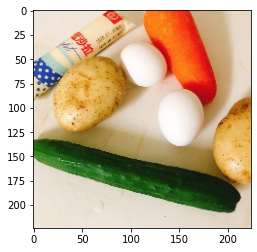

In [45]:
### 用載入的測試照片來預測 ###

test_img_paths = glob('/content/val_img/*.jpg')
# 從上面路徑抽一張出來預測
path = np.random.choice(test_img_paths, 1)[0]

# 用訓練/驗證的資料來測試效果
# path = np.random.choice(val_img_paths, 1)[0]

# ## 載入
img = im.load_img(path).resize((224, 224))
plt.imshow(img)

result_1, prediction = predict_origin(img)
print("原圖預測： ",result_1)


print("===============分隔線=================")

result_3 = predict_dynamic_cut(img, 3)
print("看起來像是有這些： ", result_3)

In [ ]:
for p, val in zip(prediction[0], trans):
    print(val, "的機率:", round(p, 3))

空心菜 的機率: 0.0
小白菜 的機率: 0.0
青江菜 的機率: 0.0
豆芽菜 的機率: 0.0
地瓜葉 的機率: 0.0
花椰菜 的機率: 0.0
芥藍菜 的機率: 0.0
大白菜 的機率: 0.0
高麗菜 的機率: 0.0
長年菜 的機率: 0.0
金針菇 的機率: 0.0
杏鮑菇 的機率: 0.0
香菇 的機率: 0.0
乾香菇 的機率: 0.0
紅蘿蔔 的機率: 1.0
白蘿蔔 的機率: 0.0
馬鈴薯 的機率: 0.0
地瓜 的機率: 0.0
雞蛋 的機率: 0.0
洋蔥 的機率: 0.0
猴頭菇 的機率: 0.0
豆腐 的機率: 0.0
板豆腐 的機率: 0.0
豆干 的機率: 0.0
韭菜 的機率: 0.0
茄子 的機率: 0.0
皮蛋 的機率: 0.0
豆皮 的機率: 0.0
